In [220]:
import sqlite3
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import urbangrammar_graphics as ugg
from scipy import stats
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, silhouette_score
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering, KMeans
from kmodes.kprototypes import KPrototypes

# 1. Извлечение данных

In [2]:
dbfile = 'shop_database.db'
conn = sqlite3.connect(dbfile)
cursor = conn.cursor()

In [3]:
cursor.execute("SELECT name \
                FROM sqlite_master \
                WHERE type = 'table'") 

print(f"Table Name: {cursor.fetchall()}")

Table Name: [('purchases',), ('personal_data_coeffs',), ('personal_data',)]


In [4]:
purchases = pd.read_sql_query("SELECT * FROM purchases", conn)
purchases.head()

,id,product,colour,cost,product_sex,base_sale,dt
0,0,"Велосипед горный женский Stern Mira 2.0 26""",белый/синий,13599,0.0,1,7
1,0,Стол Outventure,зелёный,1499,NaN,0,37
2,0,Набор Outventure: стол + 4 стула,бежевый,4799,NaN,0,37
3,3,Бутсы мужские GSD Astro,белый,1599,1.0,0,13
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,мультицвет,7199,NaN,0,27


In [5]:
personal_data_coeffs = pd.read_sql_query("SELECT * FROM personal_data_coeffs", conn)
personal_data_coeffs.head()

,id,lbt_coef,ac_coef,sm_coef,personal_coef
0,0,5.078678,-0.307147,0.959027,0.5072
1,3,7.764766,-0.030225,0.794720,0.4304
2,4,4.569378,0.063693,0.820892,0.5072
3,6,8.150379,0.075200,0.836140,0.4304
4,7,5.188231,-0.000134,0.944113,0.5072


In [6]:
personal_data = pd.read_sql_query("SELECT * FROM personal_data", conn)
conn.close()
personal_data.head()

,id,gender,age,education,city,country
0,0,0,36,среднее,1201,32
1,4,0,35,среднее,1134,32
2,6,1,52,среднее,1188,32
3,7,0,37,среднее,1198,32
4,9,0,48,среднее,1134,32


In [7]:
lost_personal_data = pd.read_csv('personal_data.csv')
lost_personal_data.head()

,id,age,education,city,country
0,101492,32,среднее,1188,32
1,42690,20,высшее,1134,32
2,113001,27,среднее,1187,32
3,163654,49,высшее,1160,32
4,69523,44,среднее,1137,32


# 2. Подготовка данных к работе

## 2.1 Фильтрация и восстановление данных в 'personal_data' и 'lost_personal_data'
**Оставляем только тех людей, которые относятся к стране с кодовым цифровым значением 32**

**personal_data**

In [8]:
personal_data.shape

(89241, 6)

In [9]:
personal_data = personal_data[personal_data['country'] == 32]
personal_data.shape

(88786, 6)

**lost_personal_data**

In [10]:
lost_personal_data.shape

(15748, 5)

In [11]:
lost_personal_data = lost_personal_data[lost_personal_data['country'] == 32]
lost_personal_data.shape

(15651, 5)

### Построение модели классификации для заполнения пустых значений в признаке 'gender'

**Кодирование 'education'**

In [12]:
personal_data_copy = personal_data.copy()

In [13]:
le = LabelEncoder()


personal_data_copy['education'] = le.fit_transform(personal_data_copy['education'])
personal_data_copy.head()

,id,gender,age,education,city,country
0,0,0,36,1,1201,32
1,4,0,35,1,1134,32
2,6,1,52,1,1188,32
3,7,0,37,1,1198,32
4,9,0,48,1,1134,32


In [14]:
y = personal_data_copy['gender']
X = personal_data_copy.loc[:, personal_data_copy.columns != 'gender']

**Разделяем данные на обучающий и тестовый наборы**

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

**Оценка корректности классификации**

In [17]:
report = classification_report(y_test, model.predict(X_test), target_names=['0', '1'])
print(report)

              precision    recall  f1-score   support

           0       0.44      0.43      0.44      7494
           1       0.59      0.60      0.60     10264

    accuracy                           0.53     17758
   macro avg       0.52      0.52      0.52     17758
weighted avg       0.53      0.53      0.53     17758



**Применяем модель к датасету lost_personal_data**

In [18]:
lost_personal_data_copy = lost_personal_data.copy()

In [19]:
lost_personal_data_copy['education'] = le.fit_transform(lost_personal_data_copy['education'])
lost_personal_data_copy.head()

,id,age,education,city,country
0,101492,32,1,1188,32
1,42690,20,0,1134,32
2,113001,27,1,1187,32
3,163654,49,0,1160,32
4,69523,44,1,1137,32


In [20]:
X_pred =  lost_personal_data_copy.loc[:, lost_personal_data_copy.columns != 'gender']

In [21]:
missing_gender = model.predict(X_pred)

**Заполнение столбца 'gender' в датасете 'lost_personal_data'**

In [22]:
lost_personal_data['gender'] = missing_gender
lost_personal_data.head()

,id,age,education,city,country,gender
0,101492,32,среднее,1188,32,0
1,42690,20,высшее,1134,32,0
2,113001,27,среднее,1187,32,1
3,163654,49,высшее,1160,32,1
4,69523,44,среднее,1137,32,0


### Объединение персональных данных в общий датасет

In [23]:
personal_data_full = pd.concat([personal_data, lost_personal_data])
personal_data_full.head()

,id,gender,age,education,city,country
0,0,0,36,среднее,1201,32
1,4,0,35,среднее,1134,32
2,6,1,52,среднее,1188,32
3,7,0,37,среднее,1198,32
4,9,0,48,среднее,1134,32


In [24]:
personal_data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104437 entries, 0 to 15747
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         104437 non-null  int64 
 1   gender     104437 non-null  int64 
 2   age        104437 non-null  int64 
 3   education  104437 non-null  object
 4   city       104437 non-null  int64 
 5   country    104437 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 5.6+ MB


In [25]:
purchases1 = purchases.copy()
personal_data_coeffs1 = personal_data_coeffs.copy()
personal_data1 = personal_data.copy()
lost_personal_data1 = lost_personal_data.copy()
personal_data_full1 = personal_data_full.copy()

## 2.2 Обработка данных в 'purchases'

In [26]:
purchases.head()

,id,product,colour,cost,product_sex,base_sale,dt
0,0,"Велосипед горный женский Stern Mira 2.0 26""",белый/синий,13599,0.0,1,7
1,0,Стол Outventure,зелёный,1499,NaN,0,37
2,0,Набор Outventure: стол + 4 стула,бежевый,4799,NaN,0,37
3,3,Бутсы мужские GSD Astro,белый,1599,1.0,0,13
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,мультицвет,7199,NaN,0,27


In [27]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786260 entries, 0 to 786259
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   id           786260 non-null  int64  
 1   product      786260 non-null  object 
 2   colour       666736 non-null  object 
 3   cost         786260 non-null  int64  
 4   product_sex  471548 non-null  float64
 5   base_sale    786260 non-null  int64  
 6   dt           786260 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 42.0+ MB


### Признак 'product' 
Избавляемся от неоднородной информации в названии товаров, оставляем только название товара, а производителя выносим в отдельный столбец

In [28]:
purchases['manufacturer'] = purchases['product'].apply(lambda x: re.findall(r'[a-zA-Z]+', x)[0] if re.findall(r'[a-zA-Z]+', x) else '')
purchases['manufacturer'] = purchases['manufacturer'].apply(lambda x: x.title())
purchases['product'] = purchases['product'].apply(lambda x: ' '.join(re.findall(r'[а-яА-Я]+', x)))
purchases = purchases[['id','product', 'colour', 'manufacturer', 'cost', 'product_sex', 'base_sale', 'dt']]
purchases.head()

,id,product,colour,manufacturer,cost,product_sex,base_sale,dt
0,0,Велосипед горный женский,белый/синий,Stern,13599,0.0,1,7
1,0,Стол,зелёный,Outventure,1499,NaN,0,37
2,0,Набор стол стула,бежевый,Outventure,4799,NaN,0,37
3,3,Бутсы мужские,белый,Gsd,1599,1.0,0,13
4,3,Мяч футбольный,мультицвет,Puma,7199,NaN,0,27


### Признак 'colour' 

**Удаляем строки, которые не заполнены по признаку 'colour', т.к. нет данных, чтобы восстановить эту информацию**

In [29]:
purchases = purchases[~purchases.colour.isna()]
purchases.shape

(666736, 8)

In [30]:
purchases.head()

,id,product,colour,manufacturer,cost,product_sex,base_sale,dt
0,0,Велосипед горный женский,белый/синий,Stern,13599,0.0,1,7
1,0,Стол,зелёный,Outventure,1499,NaN,0,37
2,0,Набор стол стула,бежевый,Outventure,4799,NaN,0,37
3,3,Бутсы мужские,белый,Gsd,1599,1.0,0,13
4,3,Мяч футбольный,мультицвет,Puma,7199,NaN,0,27


**Приводим название цветов к одному виду**

In [31]:
purchases['colour'] = purchases['colour'].apply(lambda x: x.replace('/', '-'))
purchases.head()

,id,product,colour,manufacturer,cost,product_sex,base_sale,dt
0,0,Велосипед горный женский,белый-синий,Stern,13599,0.0,1,7
1,0,Стол,зелёный,Outventure,1499,NaN,0,37
2,0,Набор стол стула,бежевый,Outventure,4799,NaN,0,37
3,3,Бутсы мужские,белый,Gsd,1599,1.0,0,13
4,3,Мяч футбольный,мультицвет,Puma,7199,NaN,0,27


### Признак 'product_sex' 

**Заполняем строки, которые не заполнены по признаку 'product_sex'** \
Заполняем значениями 'gender' из таблицы 'personal_data_full'

In [32]:
purchases = purchases.merge(personal_data_full[['id', 'gender']], on='id', how='left')
purchases['product_sex'] = purchases['product_sex'].combine_first(purchases['gender'])
purchases.drop('gender', axis=1, inplace=True)
purchases.head()

,id,product,colour,manufacturer,cost,product_sex,base_sale,dt
0,0,Велосипед горный женский,белый-синий,Stern,13599,0.0,1,7
1,0,Стол,зелёный,Outventure,1499,0.0,0,37
2,0,Набор стол стула,бежевый,Outventure,4799,0.0,0,37
3,3,Бутсы мужские,белый,Gsd,1599,1.0,0,13
4,3,Мяч футбольный,мультицвет,Puma,7199,0.0,0,27


In [33]:
# Заполнение пустых значений в столбце 'product_sex' значением по 'id'
purchases['product_sex'] = purchases.groupby('id')['product_sex'].ffill()

# Определение 'product_sex' по столбцу 'product'
def determine_product_sex(row):
    if pd.isnull(row['product_sex']):
        if 'для мальчиков' in row['product']:
            return 0.0
        elif 'для девочек' in row['product']:
            return 1.0
    return row['product_sex']

purchases['product_sex'] = purchases.apply(determine_product_sex, axis=1)
purchases.head()

,id,product,colour,manufacturer,cost,product_sex,base_sale,dt
0,0,Велосипед горный женский,белый-синий,Stern,13599,0.0,1,7
1,0,Стол,зелёный,Outventure,1499,0.0,0,37
2,0,Набор стол стула,бежевый,Outventure,4799,0.0,0,37
3,3,Бутсы мужские,белый,Gsd,1599,1.0,0,13
4,3,Мяч футбольный,мультицвет,Puma,7199,0.0,0,27


In [34]:
purchases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 666736 entries, 0 to 666735
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            666736 non-null  int64  
 1   product       666736 non-null  object 
 2   colour        666736 non-null  object 
 3   manufacturer  666736 non-null  object 
 4   cost          666736 non-null  int64  
 5   product_sex   666404 non-null  float64
 6   base_sale     666736 non-null  int64  
 7   dt            666736 non-null  int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 45.8+ MB


**Удаляем оставшиеся незаполненные строки**

In [35]:
purchases = purchases[~purchases.product_sex.isna()]
purchases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 666404 entries, 0 to 666735
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            666404 non-null  int64  
 1   product       666404 non-null  object 
 2   colour        666404 non-null  object 
 3   manufacturer  666404 non-null  object 
 4   cost          666404 non-null  int64  
 5   product_sex   666404 non-null  float64
 6   base_sale     666404 non-null  int64  
 7   dt            666404 non-null  int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 45.8+ MB


In [36]:
purchases2 = purchases.copy()

## 2.3 Данные 'personal_data_coeffs'

In [37]:
personal_data_coeffs

,id,lbt_coef,ac_coef,sm_coef,personal_coef
0,0,5.078678,-0.307147,0.959027,0.5072
1,3,7.764766,-0.030225,0.794720,0.4304
2,4,4.569378,0.063693,0.820892,0.5072
3,6,8.150379,0.075200,0.836140,0.4304
4,7,5.188231,-0.000134,0.944113,0.5072
...,...,...,...,...,...
104984,177998,4.740988,0.364797,1.165888,0.5072
104985,177999,7.303172,0.431899,1.317100,0.4304
104986,178001,5.241579,0.430391,0.356182,0.2576
104987,178002,7.542436,-0.290921,0.800338,0.4304


In [38]:
personal_data_coeffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104989 entries, 0 to 104988
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             104989 non-null  int64  
 1   lbt_coef       104989 non-null  float64
 2   ac_coef        104989 non-null  float64
 3   sm_coef        104989 non-null  float64
 4   personal_coef  104989 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 4.0 MB


Данные во всех таблицах заполнены и корректны

## 2.4 Создание общего датасета о совершенных покупках

In [39]:
df = personal_data_full.merge(personal_data_coeffs[['id','personal_coef']], on='id', how='inner') \
                       .merge(purchases, on='id', how='inner')
df = df[['id', 'product', 'colour', 'manufacturer', 'cost', 'dt', 'base_sale', 'personal_coef', 'product_sex', 'age', 'education', 'city' ]]
df.product_sex = df.product_sex.astype('int')
df.head()

,id,product,colour,manufacturer,cost,dt,base_sale,personal_coef,product_sex,age,education,city
0,0,Велосипед горный женский,белый-синий,Stern,13599,7,1,0.5072,0,36,среднее,1201
1,0,Стол,зелёный,Outventure,1499,37,0,0.5072,0,36,среднее,1201
2,0,Набор стол стула,бежевый,Outventure,4799,37,0,0.5072,0,36,среднее,1201
3,4,Роликовые коньки детские,черный-розовый,Roces,9199,0,0,0.5072,0,35,среднее,1134
4,4,Шлем,белый,Fila,4999,0,0,0.5072,0,35,среднее,1134


# 3. Анализ проведения маркетинговых кампаний

## 3.1 Подготовка данных


### Участвовавшие в рассылке

In [40]:
with open('Данные/result_data/ids_first_company_positive.txt', 'r') as f:
    file_pos = f.read()

In [41]:
file_pos

'Ids of positive AB people 88128,171960,142117,114589,146123,94080,170921,63395,113075,144095,160909,28409,564,73304,17325,157790,73503,34595,27363,93721,53448,172382,139930,125612,123890,44798,98385,101786,19213,63220,34646,16476,166187,140056,161638,107475,97026,16112,115991,124787,156828,126921,141119,115620,140837,149500,44921,85789,22927,9984,32189,76510,70726,95757,91876,66688,87987,139301,121669,158721,96365,172608,135512,9374,81980,172855,164024,24755,19656,100382,64244,164113,95935,57430,86793,146767,85744,109125,22588,18792,82490,78167,9575,80270,24922,13188,131219,135219,125439,155222,54407,112736,91207,81815,17215,136729,34887,34327,91299,147422,33146,10367,72703,146648,142790,162520,64215,53979,60330,29616,46917,94944,37777,842,173346,114329,23065,93730,95418,76520,121995,49630,35415,169037,122653,46979,127692,69577,103191,137483,138630,25626,102468,30823,142371,90951,13321,122316,42861,166060,114482,120726,77077,110314,110119,73184,130753,64033,72535,58951,76522,57385,862

In [42]:
file_pos = file_pos[26::].replace(';', ',').replace('\n','').replace(' ', ',') \
                 .replace('ahashdgfjshjsd',',').replace('dtj','') \
                 .replace('hfghfg', 'None').replace('yfsdftff', '') \
                 .split(',')
len(file_pos)

5001

In [43]:
file_pos = [x for x in file_pos if x != 'None']
len(file_pos)

5000

In [44]:
ids_pos = [int(x) for x in file_pos]
ids_pos

[88128,
 171960,
 142117,
 114589,
 146123,
 94080,
 170921,
 63395,
 113075,
 144095,
 160909,
 28409,
 564,
 73304,
 17325,
 157790,
 73503,
 34595,
 27363,
 93721,
 53448,
 172382,
 139930,
 125612,
 123890,
 44798,
 98385,
 101786,
 19213,
 63220,
 34646,
 16476,
 166187,
 140056,
 161638,
 107475,
 97026,
 16112,
 115991,
 124787,
 156828,
 126921,
 141119,
 115620,
 140837,
 149500,
 44921,
 85789,
 22927,
 9984,
 32189,
 76510,
 70726,
 95757,
 91876,
 66688,
 87987,
 139301,
 121669,
 158721,
 96365,
 172608,
 135512,
 9374,
 81980,
 172855,
 164024,
 24755,
 19656,
 100382,
 64244,
 164113,
 95935,
 57430,
 86793,
 146767,
 85744,
 109125,
 22588,
 18792,
 82490,
 78167,
 9575,
 80270,
 24922,
 13188,
 131219,
 135219,
 125439,
 155222,
 54407,
 112736,
 91207,
 81815,
 17215,
 136729,
 34887,
 34327,
 91299,
 147422,
 33146,
 10367,
 72703,
 146648,
 142790,
 162520,
 64215,
 53979,
 60330,
 29616,
 46917,
 94944,
 37777,
 842,
 173346,
 114329,
 23065,
 93730,
 95418,
 76520

### Люди, которым не предложили скидку

In [45]:
with open('Данные/result_data/ids_first_company_negative.txt', 'r') as f:
    file_neg = f.read()
file_neg

'Ids of negative AB people 82450;63400;7138;102118;153511;168450;4985;84106;83492;117102;168054;89820;62749;169114;161437;44626;170874;145877;161411;49035;56468;62835;77474;30013;55201;137781;165566;40819;101614;10027;84201;31128;96514;77779;142592;18314;48137;71286;128063;18550;70682;33862;52972;131507;45807;64262;164130;17193;108167;18712;77602;84851;33806;18813;168271;170144;141790;113883;175059;5199;67063;141940;63783;131035;29957;25195;150669;15874;8169;45630;50600;106224;114977;140090;29442;161833;156705;145568;173736;108499;145410;144617;74871;9397;43075;59380;123287;31406;135979;43728;98303;3014;164228;75809;155457;119551;7686;147106;134089;13702;136287;38219;27306;151342;97168;151349;136909;71823;162474;54410;24733;21599;89106;99224;71567;60068;141713;157428;70764;94959;77332;33517;129256;154873;94587;43729;38884;122120;137230;173829;49659;141221;154214;44269;38789;26923;26151;38744;160298;152524;147251;8225;113396;43129;83817;26930;127937;124424;142832;137831;88209;152761;165

In [46]:
file_neg = file_neg[26::].replace(';', ',').replace('\n','').replace('  ', ',').replace(' ',',')\
                         .replace('kdkdjff,,', '').replace('hsdghdshgd', '') \
                         .replace('hdhdhdhd', '').replace('|||', ',') \
                         .split(',')
len(file_neg)

5000

In [47]:
ids_neg = [int(x) for x in file_neg]
ids_neg

[82450,
 63400,
 7138,
 102118,
 153511,
 168450,
 4985,
 84106,
 83492,
 117102,
 168054,
 89820,
 62749,
 169114,
 161437,
 44626,
 170874,
 145877,
 161411,
 49035,
 56468,
 62835,
 77474,
 30013,
 55201,
 137781,
 165566,
 40819,
 101614,
 10027,
 84201,
 31128,
 96514,
 77779,
 142592,
 18314,
 48137,
 71286,
 128063,
 18550,
 70682,
 33862,
 52972,
 131507,
 45807,
 64262,
 164130,
 17193,
 108167,
 18712,
 77602,
 84851,
 33806,
 18813,
 168271,
 170144,
 141790,
 113883,
 175059,
 5199,
 67063,
 141940,
 63783,
 131035,
 29957,
 25195,
 150669,
 15874,
 8169,
 45630,
 50600,
 106224,
 114977,
 140090,
 29442,
 161833,
 156705,
 145568,
 173736,
 108499,
 145410,
 144617,
 74871,
 9397,
 43075,
 59380,
 123287,
 31406,
 135979,
 43728,
 98303,
 3014,
 164228,
 75809,
 155457,
 119551,
 7686,
 147106,
 134089,
 13702,
 136287,
 38219,
 27306,
 151342,
 97168,
 151349,
 136909,
 71823,
 162474,
 54410,
 24733,
 21599,
 89106,
 99224,
 71567,
 60068,
 141713,
 157428,
 70764,
 9495

## 3.2 Анализ первой маркетинговой кампании

In [48]:
df1 = df.query('5 <= dt <= 16')
df1

,id,product,colour,manufacturer,cost,dt,base_sale,personal_coef,product_sex,age,education,city
0,0,Велосипед горный женский,белый-синий,Stern,13599,7,1,0.5072,0,36,среднее,1201
11,6,Футболка мужская,темно-синий,Kappa,999,8,0,0.4304,1,52,среднее,1188
12,6,Бейсболка детская,синий,Nike,1119,11,1,0.4304,1,52,среднее,1188
13,6,Носки детские пары,синий-серый,Demix,299,11,0,0.4304,1,52,среднее,1188
14,6,Кроссовки мужские,черный,Adidas,7399,11,0,0.4304,1,52,среднее,1188
...,...,...,...,...,...,...,...,...,...,...,...,...
660909,135183,Ботинки женские,голубой-серый,Scarpa,18199,13,0,0.4304,0,44,среднее,1134
660913,125993,Сандалии женские,черный-серый,Merrell,6999,7,0,0.4304,0,46,среднее,1134
660915,167019,Рубашка с коротким рукавом женская,синий-зеленый,Termit,1999,6,0,0.5072,0,71,среднее,1134
660919,116355,Велосипед горный,черный,Trek,69999,10,0,0.4304,1,32,среднее,1188


In [49]:
df1_control = df.query('id in @ids_neg and 5 <= dt <= 16')
df1_control

,id,product,colour,manufacturer,cost,dt,base_sale,personal_coef,product_sex,age,education,city
90,23,Шорты женские,черный,Demix,1999,16,0,0.4304,0,44,среднее,1178
91,23,Лиф женский,коралловый,Joss,649,16,1,0.4304,0,44,среднее,1178
214,70,Сандалии женские,графитовый,Outventure,3999,5,0,0.5584,0,31,высшее,1185
215,70,Кроссовки мужские,хаки,Fila,5999,16,0,0.5584,1,31,высшее,1185
470,168,Жилет утепленный женский,темно-коричневый,Outventure,3499,14,0,0.5072,0,32,среднее,1134
...,...,...,...,...,...,...,...,...,...,...,...,...
660834,121124,Полуботинки женские,серый,Skechers,4899,16,1,0.5072,0,38,среднее,1134
660835,121124,Ботинки утепленные женские,светло-коричневый,Skechers,5319,16,1,0.5072,0,38,среднее,1134
660867,11558,Рюкзак,розовый-серый,Demix,1049,15,1,0.5072,1,33,среднее,1185
660868,11558,Рюкзак,синий-розовый,Dc,1699,16,1,0.5072,1,33,среднее,1185


In [50]:
df1_test = df.query('id in @ids_pos and 5 <= dt <= 16')
df1_test

,id,product,colour,manufacturer,cost,dt,base_sale,personal_coef,product_sex,age,education,city
202,67,Фонарь кемпинговый,белый,Outventure,499,9,0,0.4304,1,38,среднее,1168
203,67,Коврик самонадувающийся см,вишнёвый,Northland,2999,9,0,0.4304,1,38,среднее,1168
204,67,Спиннинг телескопический стеклопластиковый к с м,мультицвет,Fish,445,9,1,0.4304,1,38,среднее,1168
205,67,Леска плетеная,желтый,Pontoon,625,9,0,0.4304,1,38,среднее,1168
206,67,Матрас надувной х х см,серый-голубой,Intex,1979,9,1,0.4304,1,38,среднее,1168
...,...,...,...,...,...,...,...,...,...,...,...,...
660879,105219,Носки пары,черный,Adidas,1199,7,0,0.4688,0,46,высшее,1134
660880,105219,Солнцезащитные очки,мультицвет,Demix,1189,7,1,0.4688,0,46,высшее,1134
660881,105219,Лапа,черный,Demix,1299,7,0,0.4688,0,46,высшее,1134
660882,105219,Чехол для очков,синий,Kappa,199,7,0,0.4688,0,46,высшее,1134


### Проверка эффективности

**Гипотеза: выручка в контрольной группе равна выручке в тестовой(те, кому предоставили скидку через email-рассылку)**

In [51]:
stats.ttest_ind(df1_control.cost, df1_test.cost, alternative='greater')

Ttest_indResult(statistic=3.3209323162241833, pvalue=0.0004489921897171528)

p-value очень мало, следовательно принимаем альтернативную гипотезу - выручка среди клиентов, которым предоставили скидку через email-рассылку выше, чем среди тех, кому ее не предоставили

In [52]:
revenue_df1_control = df1_control.groupby('dt', as_index=False).agg(revenue=('cost', 'sum'))
revenue_df1_control

,dt,revenue
0,5,3350523
1,6,3679707
2,7,5154773
3,8,4970931
4,9,5126369
5,10,5616192
6,11,5105110
7,12,4581167
8,13,5006307
9,14,7664295


In [53]:
revenue_df1_test = df1_test.groupby('dt', as_index=False).agg(revenue=('cost', 'sum'))
revenue_df1_test

,dt,revenue
0,5,9572099
1,6,9518351
2,7,9695885
3,8,10151127
4,9,9891813
5,10,11146323
6,11,8871688
7,12,8140536
8,13,10094616
9,14,11478942


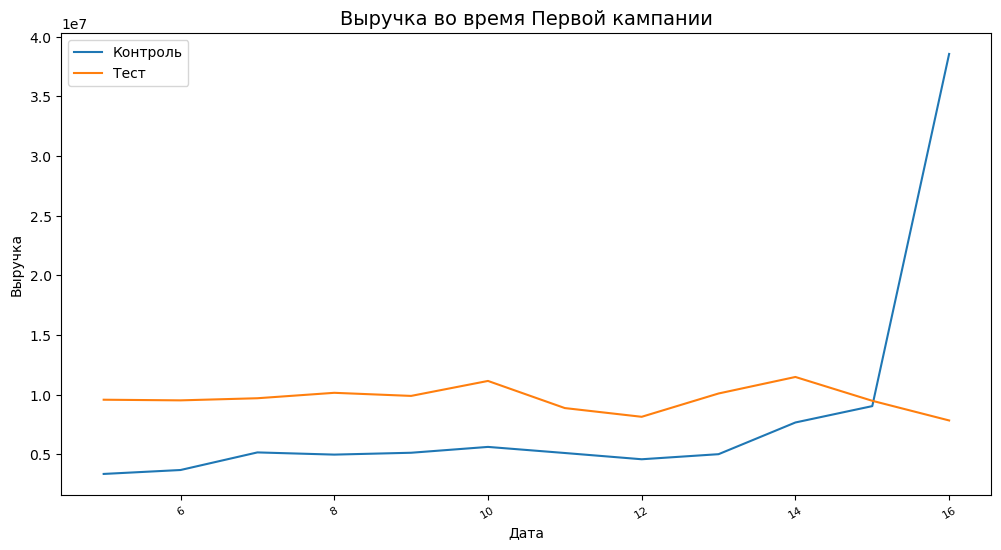

In [54]:
plt.figure(figsize=(12,6))
plt.plot('dt', 'revenue', 
         data = revenue_df1_control,
         label = 'Контроль')
plt.plot('dt', 'revenue', 
         data = revenue_df1_test,
         label = 'Тест')
plt.title('Выручка во время Первой кампании', fontsize=14)
plt.xticks(fontsize=8, rotation=30)
plt.xlabel('Дата', fontsize=10)
plt.ylabel('Выручка', fontsize=10)
plt.legend()
plt.show()

### Основные метрики

**Конверсия в покупку**

In [55]:
CR_control = df1_control.id.nunique() / df1.id.nunique()
CR_control

0.06700725067658508

In [56]:
CR_test = df1_test.id.nunique() / df1.id.nunique()
CR_test

0.06550212020782378

In [57]:
print('Изменение конверсии в покупку после проведения теста', round((CR_test - CR_control) * 100, 2), 'п.п.')

Изменение конверсии в покупку после проведения теста -0.15 п.п.


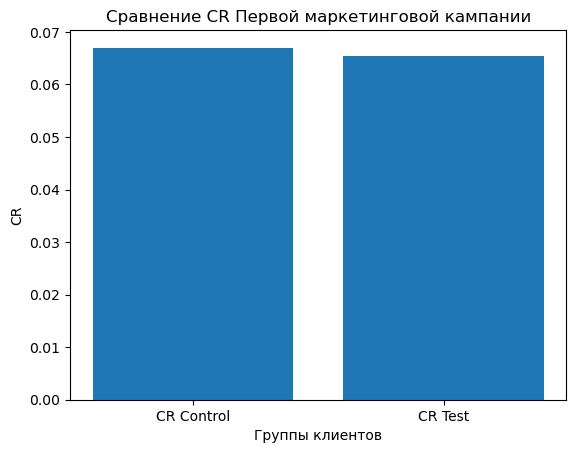

In [58]:
data = {'CR Control': 0.067, 'CR Test': 0.0655}
plt.bar(data.keys(), data.values())
plt.xlabel('Группы клиентов')
plt.ylabel('СR')
plt.title('Сравнение CR Первой маркетинговой кампании')
plt.show()

**Средний чек**

In [59]:
avg_bill_control = df1_control.groupby('id').agg({'cost':'mean'}).mean()
avg_bill_control

cost    6041.276184
dtype: float64

In [60]:
avg_bill_test = df1_test.groupby('id').agg({'cost':'mean'}).mean()
avg_bill_test

cost    5704.317457
dtype: float64

In [61]:
print('Изменение размера среднего чека после проведения теста', round(avg_bill_test - avg_bill_control, 2))

Изменение размера среднего чека после проведения теста cost   -336.96
dtype: float64


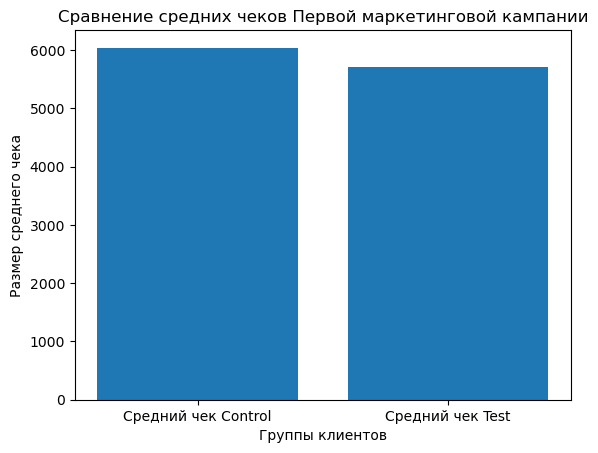

In [62]:
data = {'Средний чек Control': 6041.27, 'Средний чек Test': 5704.31}
plt.bar(data.keys(), data.values())
plt.xlabel('Группы клиентов')
plt.ylabel('Размер среднего чека')
plt.title('Сравнение средних чеков Первой маркетинговой кампании')
plt.show()

### Выводы:

На основании результатов анализа A/B-тестирования, можно сделать следующие выводы и дать бизнес-рекомендации:

1. **Выручка:** Полученное значение t-теста указывает на то, что выручка среди клиентов, которым предоставили скидку через email-рассылку, выше, чем среди тех, кому скидку не предоставили. Это говорит о том, что персональные скидки через email-рассылку могут быть эффективным инструментом для увеличения выручки. 

2. **Конверсия в покупку:** Изменение конверсии в покупку после проведения теста на уровне -0.15 п.п. говорит о том, что маркетинговая кампания не привела к значительному увеличению числа покупателей. 

3. **Размер среднего чека:** Изменение размера среднего чека после проведения теста на уровне -336.96 указывает на то, что средний чек уменьшился. Возможно, это связано с тем, что клиенты стали покупать более дешевые товары или в меньшем количестве из-за предоставленных скидок. 

4. **Бизнес-рекомендации:**
   - Продолжать использовать персональные скидки через email-рассылку для увеличения выручки.
   - Провести дополнительные исследования для повышения конверсии в покупку.
   - Оптимизировать товарный ассортимент и ценовую политику для увеличения размера среднего чека.

## 3.3 Анализ второй маркетинговой кампании

**Создадим 2 датасета, отражающих продажи в 15 и 45 день**

In [63]:
df2_15 = df.query('dt == 15 and city == 1134')
df2_15

,id,product,colour,manufacturer,cost,dt,base_sale,personal_coef,product_sex,age,education,city
340,101,Джемпер флисовый женский,небесный,Outventure,4499,15,0,0.5072,0,33,среднее,1134
421,130,Ботинки утепленные женские,серый,Geox,5999,15,1,0.5072,0,63,среднее,1134
440,148,Бейсболка детская,милитари,Outventure,799,15,0,0.5072,0,40,среднее,1134
441,148,Майка женская,черный,Asics,1749,15,1,0.5072,0,40,среднее,1134
472,168,Футболка женская,белый,Termit,909,15,1,0.5072,0,32,среднее,1134
...,...,...,...,...,...,...,...,...,...,...,...,...
660712,130052,Кроссовки мужские,бежевый,Fila,5999,15,0,0.4304,1,39,среднее,1134
660847,97334,Велосипедки женские,мультицвет,Protest,1799,15,0,0.5072,0,32,среднее,1134
660848,97334,Рубашка с коротким рукавом женская,мультицвет,Protest,2399,15,0,0.5072,0,32,среднее,1134
660856,3646,Лента силовая,фиолетовый,Demix,999,15,0,0.4304,1,58,среднее,1134


In [64]:
df2_45 = df.query('dt == 45 and city == 1134')
df2_45

,id,product,colour,manufacturer,cost,dt,base_sale,personal_coef,product_sex,age,education,city
324,98,,зеленый,Sup,28500,45,0,0.5072,0,31,среднее,1134
724,287,Кеды мужские,белый-красный,Adidas,3849,45,1,0.4304,1,54,среднее,1134
725,287,Костюм спортивный мужской,черный,Nike,10799,45,0,0.4304,1,54,среднее,1134
1055,392,Кроссовки женские,черный-розовый,True,5249,45,1,0.5072,0,26,среднее,1134
1056,392,Спортивный топ бра,чёрный,Demix,3299,45,0,0.5072,0,26,среднее,1134
...,...,...,...,...,...,...,...,...,...,...,...,...
659543,86644,Худи для девочек,черный,Fila,1349,45,1,0.4304,1,36,среднее,1134
660477,29191,Рюкзак л,темно-синий,Tatonka,25799,45,0,0.4304,1,33,среднее,1134
660838,121124,Носки пары,розовый-голубой,Kappa,199,45,1,0.5072,1,38,среднее,1134
660910,135183,Бриджи женские,черный,Salomon,4899,45,1,0.4304,0,44,среднее,1134


### Основные метрики

**Выручка**

In [65]:
sales_15 = df2_15.cost.sum()
sales_15

32501116

In [66]:
sales_45 = df2_45.cost.sum()
sales_45

17554624

In [67]:
print('Изменение размера выручки', sales_45 - sales_15)

Изменение размера выручки -14946492


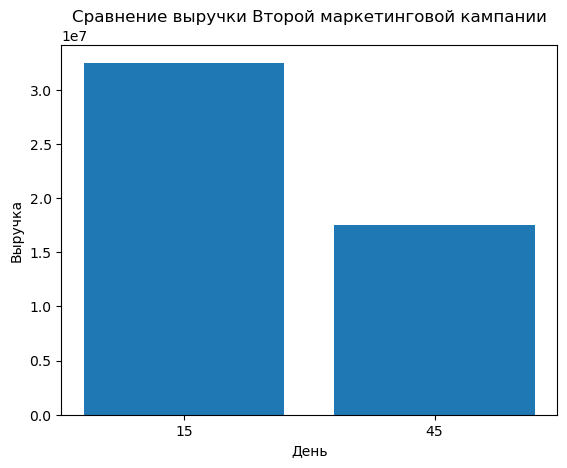

In [68]:
data = {'15': 32501116, '45': 17554624}
plt.bar(data.keys(), data.values())
plt.xlabel('День')
plt.ylabel('Выручка')
plt.title('Сравнение выручки Второй маркетинговой кампании')
plt.show()

**Средний чек**

In [69]:
avg_bill_15 = df2_15.groupby('id').agg({'cost':'mean'}).mean()
avg_bill_15

cost    6240.162037
dtype: float64

In [70]:
avg_bill_45 = df2_45.groupby('id').agg({'cost':'mean'}).mean()
avg_bill_45

cost    6387.843876
dtype: float64

In [71]:
print('Изменение размера среднего чека', round(avg_bill_45 - avg_bill_15, 2))

Изменение размера среднего чека cost    147.68
dtype: float64


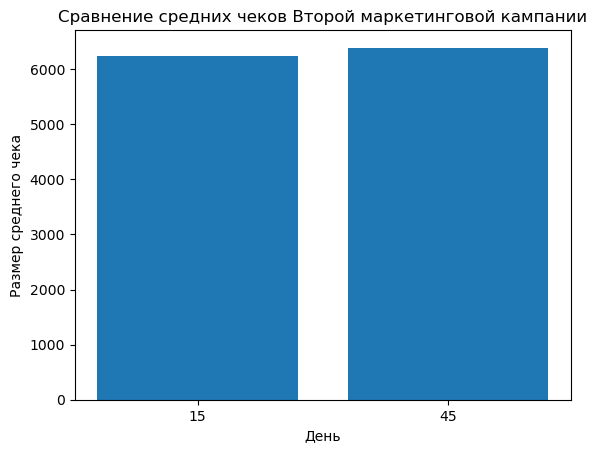

In [72]:
data = {'15': 6240.16, '45': 6387.84}
plt.bar(data.keys(), data.values())
plt.xlabel('День')
plt.ylabel('Размер среднего чека')
plt.title('Сравнение средних чеков Второй маркетинговой кампании')
plt.show()

**Количество чеков**

In [73]:
bills_15 = df2_15.id.nunique()
bills_15

3149

In [74]:
bills_45 = df2_45.id.nunique()
bills_45

1682

In [75]:
print('Изменение количества покупателей', bills_45 - bills_15)

Изменение количества покупателей -1467


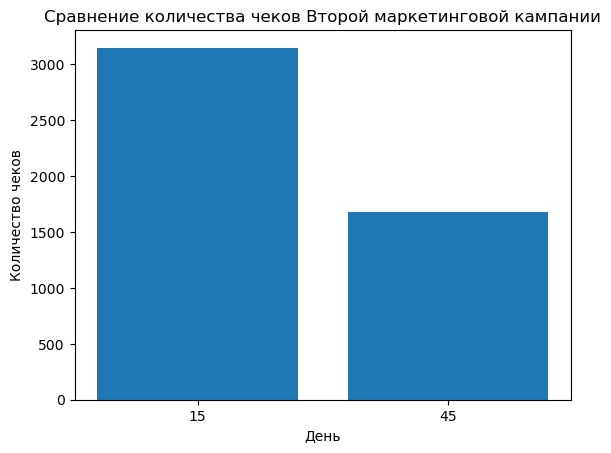

In [76]:
data = {'15': 3149, '45': 1682}
plt.bar(data.keys(), data.values())
plt.xlabel('День')
plt.ylabel('Количество чеков')
plt.title('Сравнение количества чеков Второй маркетинговой кампании')
plt.show()

### Выводы:

Исходя из результатов проведенной кампании баннерной рекламы на билбордах с предложением скидки каждое 15-е число месяца для жителей города 1 134, можно сделать следующие выводы и дать бизнес-рекомендации:

1. **Выручка:** Уменьшение размера выручки на 14 946 492 единиц говорит о том, что кампания не привела к увеличению доходов компании. Возможно, предложение скидки каждое 15-е число месяца не оказалось достаточно привлекательным для целевой аудитории. 

2. **Размер среднего чека:** Увеличение размера среднего чека на 147.68 указывает на то, что клиенты стали делать более крупные покупки в рамках кампании. Это может быть связано с привлекательностью предложения скидки и стимулированием клиентов делать дополнительные покупки.

3. **Количество покупателей:** Снижение количества покупателей на 1467 человек может быть связано с неэффективностью баннерной рекламы на билбордах в привлечении новых клиентов. 

4. **Бизнес-рекомендации:**
   - Провести анализ предпочтений и потребностей жителей города для разработки более целевых маркетинговых стратегий.
   - Разнообразить маркетинговые каналы и использовать комбинацию онлайн и офлайн инструментов для привлечения новых клиентов.
   - Продолжать стимулировать клиентов на совершение дополнительных покупок через предложения скидок и акций.

# 4. Кластеризация

## 4.1 Подготовка данных

In [77]:
df.shape

(660936, 12)

In [78]:
df_cl = df.head(100006)
df_cl

,id,product,colour,manufacturer,cost,dt,base_sale,personal_coef,product_sex,age,education,city
0,0,Велосипед горный женский,белый-синий,Stern,13599,7,1,0.5072,0,36,среднее,1201
1,0,Стол,зелёный,Outventure,1499,37,0,0.5072,0,36,среднее,1201
2,0,Набор стол стула,бежевый,Outventure,4799,37,0,0.5072,0,36,среднее,1201
3,4,Роликовые коньки детские,черный-розовый,Roces,9199,0,0,0.5072,0,35,среднее,1134
4,4,Шлем,белый,Fila,4999,0,0,0.5072,0,35,среднее,1134
...,...,...,...,...,...,...,...,...,...,...,...,...
100001,31260,Сабо,салатовый,Crocs,4599,43,0,0.4688,1,24,высшее,1192
100002,31260,Носки пары,белый,Demix,449,50,0,0.4688,1,24,высшее,1192
100003,31260,Ветровка мужская,синий,Columbia,3899,55,1,0.4688,1,24,высшее,1192
100004,31260,Кеды мужские,белый-коричневый-черный,Nike,19999,55,0,0.4688,1,24,высшее,1192


In [79]:
le = LabelEncoder()

In [80]:
df_cl['product'] = le.fit_transform(df_cl['product'])
df_cl['colour'] = le.fit_transform(df_cl['colour'])
df_cl['manufacturer'] = le.fit_transform(df_cl['manufacturer'])
df_cl['education'] = le.fit_transform(df_cl['education'])

df_cl.head()

C:\Users\Ekaterina\AppData\Local\Temp\ipykernel_7072\3767432949.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cl['product'] = le.fit_transform(df_cl['product'])
C:\Users\Ekaterina\AppData\Local\Temp\ipykernel_7072\3767432949.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cl['colour'] = le.fit_transform(df_cl['colour'])
C:\Users\Ekaterina\AppData\Local\Temp\ipykernel_7072\3767432949.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

,id,product,colour,manufacturer,cost,dt,base_sale,personal_coef,product_sex,age,education,city
0,0,254,163,358,13599,7,1,0.5072,0,36,1,1201
1,0,1963,368,272,1499,37,0,0.5072,0,36,1,1201
2,0,1296,35,272,4799,37,0,0.5072,0,36,1,1201
3,4,1713,1110,305,9199,0,0,0.5072,0,35,1,1134
4,4,2361,75,116,4999,0,0,0.5072,0,35,1,1134


In [81]:
ss = StandardScaler()
df_ss = ss.fit_transform(df_cl)
df_ss

array([[-1.74784109, -1.41569325, -1.45085673, ..., -0.16590457,
         0.50048117,  0.37235953],
       [-1.74784109,  0.94680379, -0.88522923, ..., -0.16590457,
         0.50048117,  0.37235953],
       [-1.74784109,  0.02475258, -1.80402903, ..., -0.16590457,
         0.50048117,  0.37235953],
       ...,
       [ 1.74863388, -1.31892625,  0.32604138, ..., -1.1489173 ,
        -1.99807715,  0.32058885],
       [ 1.74863388, -0.76735439, -1.61364709, ..., -1.1489173 ,
        -1.99807715,  0.32058885],
       [ 1.74863388, -0.49778919, -1.46741168, ..., -1.1489173 ,
        -1.99807715,  0.32058885]])

## 4.2 Визуализация данных с помощью метода снижения размерности t-SNE

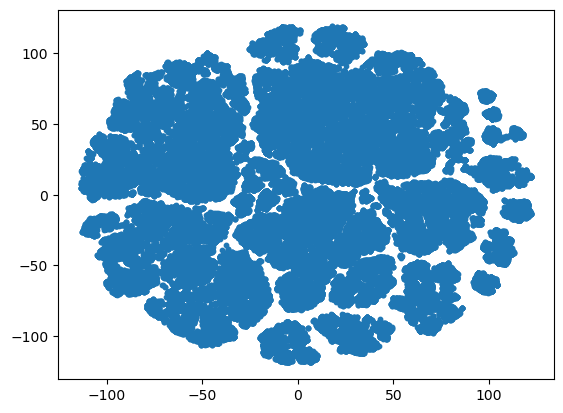

In [82]:
tsne = TSNE(n_components=2)
df_tsne = tsne.fit_transform(df_ss)
plt.scatter(df_tsne[:, 0], df_tsne[:, 1], s=10);

Данные разбились на группы по схожести признаков

## 4.3 Кластеризация

### 4.3.1 Иерархическая кластеризация

In [75]:
clustering = AgglomerativeClustering(linkage='complete').fit(df_ss)
plt.scatter(df_tsne[:, 0], df_tsne[:, 1], s=10, c=clustering.labels_);

MemoryError: Unable to allocate 37.3 GiB for an array with shape (5000550015,) and data type float64

### 4.3.2 Вероятностная кластеризация

**Применим тип кластеризации KPrototypes** \
С количеством кластеров, равным 5.

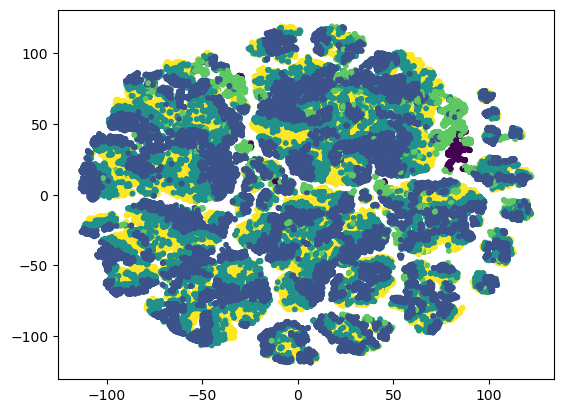

In [83]:
kproto = KPrototypes(n_clusters=5, init='Cao').fit(df_cl.values, categorical=[1, 2, 3, 10])
plt.scatter(df_tsne[:, 0], df_tsne[:, 1], s=10, c=kproto.labels_);

### 4.3.3 Метод локтя

**Применим тип кластеризации KMean** \
С количеством кластеров, равным 5.

C:\Users\Ekaterina\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


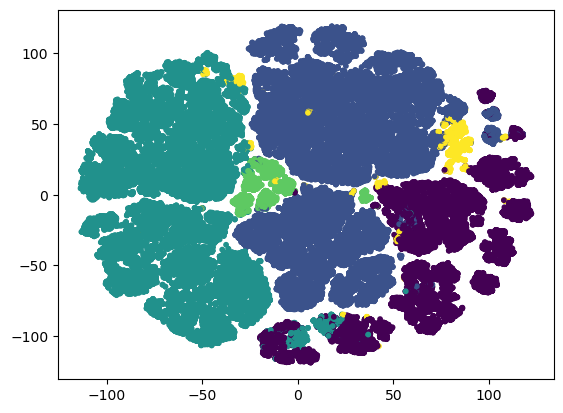

In [90]:
kmeans = KMeans(n_clusters=5).fit(df_ss)
plt.scatter(df_tsne[:, 0], df_tsne[:, 1], s=10, c=kmeans.labels_);

C:\Users\Ekaterina\anaconda3\Lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


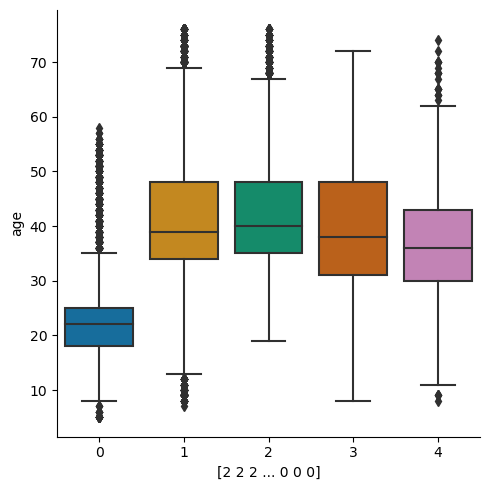

In [91]:
sns.catplot(kind='box', data=df_cl, y='age', x=kmeans.labels_, palette='colorblind', sharey=False)
plt.tight_layout()
plt.show()

In [85]:
inertia = []
silhouette = []
N = 15
for k in range(2, N):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(df_ss)
    preds = kmeans.predict(df_ss)
    inertia.append(np.sqrt(kmeans.inertia_))
    silhouette.append(silhouette_score(df_ss, preds))

C:\Users\Ekaterina\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Ekaterina\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Ekaterina\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Ekaterina\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. 

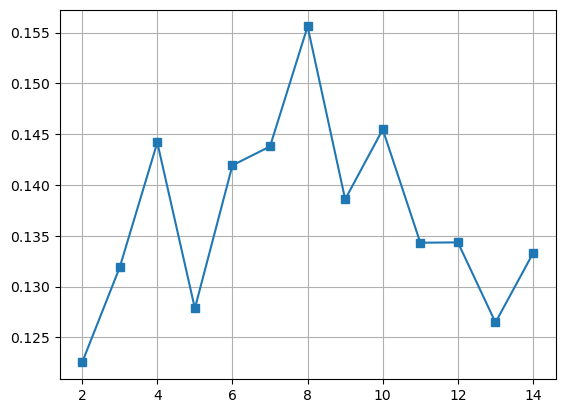

In [86]:
plt.plot(np.arange(2, N), silhouette, marker='s')
plt.grid()
plt.show()

### 4.3.4 Визуализируем профиль усредненного объекта кластеров

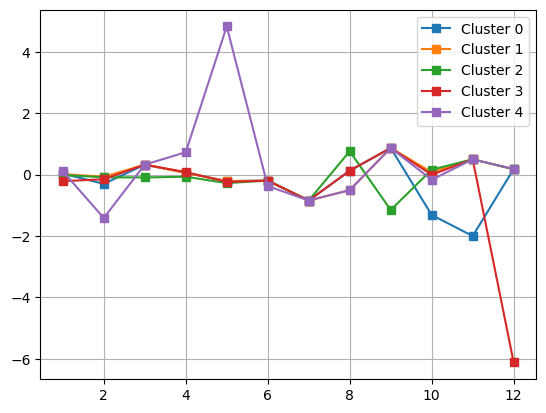

In [92]:
plt.plot(range(1, df_ss.shape[1]+1), np.median(df_ss[kmeans.labels_==0, :], axis=0), marker='s', label='Cluster 0')
plt.plot(range(1, df_ss.shape[1]+1), np.median(df_ss[kmeans.labels_==1, :], axis=0), marker='s', label='Cluster 1')
plt.plot(range(1, df_ss.shape[1]+1), np.median(df_ss[kmeans.labels_==2, :], axis=0), marker='s', label='Cluster 2')
plt.plot(range(1, df_ss.shape[1]+1), np.median(df_ss[kmeans.labels_==3, :], axis=0), marker='s', label='Cluster 3')
plt.plot(range(1, df_ss.shape[1]+1), np.median(df_ss[kmeans.labels_==4, :], axis=0), marker='s', label='Cluster 4')

plt.legend()
plt.grid()
plt.show()

Мы видим, что для всех кластеров(кроме 4) первые 7 признаков почти полностью совпадают, а потом в кластерах 0, 2, и 3 на разных отрезах идет разбиение.

## 4.4 Группировка данных по кластерам

In [93]:
kmeans1 = KMeans(n_clusters=5)
clusters = kmeans1.fit_predict(df_ss)
df_cl['cluster'] = clusters
df_cl.head()

C:\Users\Ekaterina\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Ekaterina\AppData\Local\Temp\ipykernel_7072\587975255.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cl['cluster'] = clusters


,id,product,colour,manufacturer,cost,dt,base_sale,personal_coef,product_sex,age,education,city,cluster
0,0,254,163,358,13599,7,1,0.5072,0,36,1,1201,4
1,0,1963,368,272,1499,37,0,0.5072,0,36,1,1201,4
2,0,1296,35,272,4799,37,0,0.5072,0,36,1,1201,4
3,4,1713,1110,305,9199,0,0,0.5072,0,35,1,1134,4
4,4,2361,75,116,4999,0,0,0.5072,0,35,1,1134,4


In [94]:
df_cl[['product', 'colour', 'manufacturer', 'education']] = df[['product', 'colour', 'manufacturer', 'education']]
df_cl

C:\Users\Ekaterina\AppData\Local\Temp\ipykernel_7072\4224488386.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cl[['product', 'colour', 'manufacturer', 'education']] = df[['product', 'colour', 'manufacturer', 'education']]


,id,product,colour,manufacturer,cost,dt,base_sale,personal_coef,product_sex,age,education,city,cluster
0,0,Велосипед горный женский,белый-синий,Stern,13599,7,1,0.5072,0,36,среднее,1201,4
1,0,Стол,зелёный,Outventure,1499,37,0,0.5072,0,36,среднее,1201,4
2,0,Набор стол стула,бежевый,Outventure,4799,37,0,0.5072,0,36,среднее,1201,4
3,4,Роликовые коньки детские,черный-розовый,Roces,9199,0,0,0.5072,0,35,среднее,1134,4
4,4,Шлем,белый,Fila,4999,0,0,0.5072,0,35,среднее,1134,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
100001,31260,Сабо,салатовый,Crocs,4599,43,0,0.4688,1,24,высшее,1192,0
100002,31260,Носки пары,белый,Demix,449,50,0,0.4688,1,24,высшее,1192,0
100003,31260,Ветровка мужская,синий,Columbia,3899,55,1,0.4688,1,24,высшее,1192,0
100004,31260,Кеды мужские,белый-коричневый-черный,Nike,19999,55,0,0.4688,1,24,высшее,1192,0


In [126]:
cl0 = df_cl[df_cl['cluster'] == 0]
cl0.head(25)

,id,product,colour,manufacturer,cost,dt,base_sale,personal_coef,product_sex,age,education,city,cluster
89,21,Кеды женские,белый-голубой,Li,8499,0,0,0.5584,0,19,высшее,1198,0
98,25,Худи мужская,красный-белый,Adidas,4299,2,0,0.4688,1,20,высшее,1157,0
116,39,Полуботинки мужские,черный-бежевый,Salomon,19599,30,0,0.4688,1,21,высшее,1188,0
117,39,Футболка мужская,морской,Termit,599,43,0,0.4688,1,21,высшее,1188,0
118,39,Лонгслив мужской,чёрный,Demix,499,43,1,0.4688,1,21,высшее,1188,0
119,39,Бомбер мужской,тёмно-синий,New,5599,45,1,0.4688,1,21,высшее,1188,0
120,39,Ветровка мужская,черный,Camel,5499,45,0,0.4688,1,21,высшее,1188,0
121,39,Куртка мужская,ореховый,Outventure,3999,45,1,0.4688,1,21,высшее,1188,0
122,39,Футболка мужская,желтый,Demix,799,47,1,0.4688,1,21,высшее,1188,0
123,40,Кроссовки женские,черный-белый,Nike,17999,5,0,0.4688,0,35,высшее,1188,0


In [98]:
cl0.shape

(14976, 13)

In [111]:
cl0.id.nunique()

2460

In [124]:
cl0.base_sale.value_counts()

0    9266
1    5710
Name: base_sale, dtype: int64

In [107]:
cl0.personal_coef.value_counts()

0.4688    10634
0.5584     4342
Name: personal_coef, dtype: int64

In [119]:
cl0.product_sex.value_counts()

1    10656
0     4320
Name: product_sex, dtype: int64

In [174]:
cl0.age.mean()

26.430755876068375

In [109]:
cl0.education.value_counts()

высшее    14976
Name: education, dtype: int64

In [110]:
cl0.city.value_counts()

1134    3070
1188    1208
1157     798
1204     665
1178     579
        ... 
804        3
1016       3
907        2
913        2
615        1
Name: city, Length: 92, dtype: int64

Исходя из полученных данных можно сделать вывод о том, что в кластор 0 попали клиенты с высшим образованием, преимущественно мужчины, разных возрастных категорий

In [144]:
cl1 = df_cl[df_cl['cluster'] == 1]
cl1.head(25)

,id,product,colour,manufacturer,cost,dt,base_sale,personal_coef,product_sex,age,education,city,cluster
9,6,Кроссовки для мальчиков,лимонный-черный,Geox,4999,1,0,0.4304,1,52,среднее,1188,1
10,6,Кеды мужские,черный,Reebok,4799,3,1,0.4304,1,52,среднее,1188,1
11,6,Футболка мужская,темно-синий,Kappa,999,8,0,0.4304,1,52,среднее,1188,1
12,6,Бейсболка детская,синий,Nike,1119,11,1,0.4304,1,52,среднее,1188,1
13,6,Носки детские пары,синий-серый,Demix,299,11,0,0.4304,1,52,среднее,1188,1
14,6,Кроссовки мужские,черный,Adidas,7399,11,0,0.4304,1,52,среднее,1188,1
15,6,Кроссовки мужские,черный,Adidas,7399,13,0,0.4304,1,52,среднее,1188,1
16,6,Куртка утепленная мужская,чёрный,Columbia,11999,17,0,0.4304,1,52,среднее,1188,1
17,6,Кроссовки мужские,черный-красный-белый,Nike,23999,18,0,0.4304,1,52,среднее,1188,1
18,6,Джемпер футбольный мужской,черный-белый,Nike,5999,18,0,0.4304,1,52,среднее,1188,1


In [136]:
cl1.shape

(41100, 13)

In [120]:
cl1.id.nunique()

7919

In [137]:
cl1.base_sale.value_counts()

0    25971
1    15129
Name: base_sale, dtype: int64

In [138]:
cl1.personal_coef.value_counts()

0.4304    35599
0.5072     5440
0.4688       61
Name: personal_coef, dtype: int64

In [139]:
cl1.product_sex.value_counts()

1    41090
0       10
Name: product_sex, dtype: int64

In [177]:
cl1.age.mean()

41.587250608272505

In [155]:
cl1.education.value_counts()

среднее    41039
высшее        61
Name: education, dtype: int64

In [161]:
cl2 = df_cl[df_cl['cluster'] == 2]
cl2.head(25)

,id,product,colour,manufacturer,cost,dt,base_sale,personal_coef,product_sex,age,education,city,cluster
81,20,Ремонтный комплект,мультицвет,Bestway,479,5,0,0.5072,0,33,среднее,574,2
82,20,Лодка надувная,зеленый,Bestway,5849,5,1,0.5072,0,33,среднее,574,2
83,20,Сменный клапан для матраса,черный,Bestway,399,5,0,0.5072,0,33,среднее,574,2
84,20,Лодка надувная,зеленый,Bestway,5849,6,1,0.5072,0,33,среднее,574,2
85,20,Сменный клапан для матраса,черный,Bestway,399,6,0,0.5072,0,33,среднее,574,2
86,20,Ремонтный комплект,мультицвет,Bestway,479,6,0,0.5072,0,33,среднее,574,2
87,20,Лодка надувная,зеленый,Bestway,5849,9,1,0.5072,0,33,среднее,574,2
88,20,Палатка местная,темно-зелёный,Outventure,4999,27,0,0.5072,0,33,среднее,574,2
394,112,Шапочка для плавания женская,черный-красный,Joss,899,50,0,0.2672,0,18,высшее,74,2
395,112,Слипоны мужские,синий,Skechers,2999,57,1,0.2672,1,18,высшее,74,2


In [146]:
cl2.shape

(2761, 13)

In [147]:
cl2.id.nunique()

413

In [151]:
cl2.base_sale.value_counts()

0    1592
1    1169
Name: base_sale, dtype: int64

In [152]:
cl2.personal_coef.value_counts()

0.4304    1099
0.5072    1026
0.4688     334
0.2672     120
0.5584     104
0.2576      41
0.2768      27
0.2896      10
Name: personal_coef, dtype: int64

In [159]:
cl2.product_sex.value_counts()

1    1644
0    1117
Name: product_sex, dtype: int64

In [178]:
cl2.age.mean()

38.86490402028251

In [153]:
cl2.education.value_counts()

среднее    2193
высшее      568
Name: education, dtype: int64

In [157]:
cl2.city.value_counts()

33     230
34     165
9      165
7      150
73     146
      ... 
154      1
125      1
501      1
292      1
461      1
Name: city, Length: 136, dtype: int64

In [184]:
cl3 = df_cl[df_cl['cluster'] == 3]
cl3.tail(50)

,id,product,colour,manufacturer,cost,dt,base_sale,personal_coef,product_sex,age,education,city,cluster
99140,30973,Сабо,голубой,Crocs,4599,54,0,0.2672,1,18,высшее,1188,3
99141,30973,Шлепанцы мужские,черный,Ellesse,3299,54,0,0.2672,1,18,высшее,1188,3
99235,31011,Кроссовки мужские,белый-черный,Adidas,6999,35,0,0.2672,1,17,высшее,1189,3
99236,31012,Коврик для йоги,черный-желтый,Kettler,1399,13,0,0.2896,0,15,высшее,1134,3
99237,31012,Слипоны женские,бежевый,Skechers,3499,28,1,0.2896,0,15,высшее,1134,3
99238,31012,Полуботинки женские,золотой,Skechers,4899,28,1,0.2896,0,15,высшее,1134,3
99368,31074,Кроссовки мужские,белый,Fila,5999,7,0,0.2768,1,16,среднее,1134,3
99369,31074,Рюкзак,розовый-черный,Demix,799,33,1,0.2768,0,16,среднее,1134,3
99370,31074,Кроссовки женские,кремовый,Kappa,4199,40,1,0.2768,0,16,среднее,1134,3
99371,31074,Шорты плавательные мужские,красный-синий,Fila,2299,55,0,0.2768,1,16,среднее,1134,3


In [163]:
cl3.shape

(5467, 13)

In [164]:
cl3.id.nunique()

897

In [169]:
cl3.base_sale.value_counts()

0    3203
1    2264
Name: base_sale, dtype: int64

In [170]:
cl3.personal_coef.value_counts()

0.2672    3014
0.2896    1227
0.2576     770
0.2768     456
Name: personal_coef, dtype: int64

In [171]:
cl3.product_sex.value_counts()

1    3587
0    1880
Name: product_sex, dtype: int64

In [173]:
cl3.age.mean()

15.288275105176513

In [179]:
cl3.education.value_counts()

высшее     4241
среднее    1226
Name: education, dtype: int64

In [180]:
cl3.city.value_counts()

1134    1562
1188     584
1201     277
1183     203
1157     175
        ... 
1200       2
1139       2
802        2
911        1
1206       1
Name: city, Length: 77, dtype: int64

In [196]:
cl4 = df_cl[df_cl['cluster'] == 4]
cl4.tail(20)

,id,product,colour,manufacturer,cost,dt,base_sale,personal_coef,product_sex,age,education,city,cluster
99893,31214,Балетки женские,персиковый,Demix,3799,3,0,0.5072,0,42,среднее,1183,4
99894,31214,Напульсник,черный-белый,Wilson,1599,7,0,0.5072,0,42,среднее,1183,4
99895,31214,Футболка женская,голубой,Outventure,1199,7,0,0.5072,0,42,среднее,1183,4
99896,31214,Бейсболка,зеленый,Everlast,2299,7,0,0.5072,0,42,среднее,1183,4
99898,31214,Бейсболка,светло-серый,Demix,449,21,1,0.5072,0,42,среднее,1183,4
99899,31214,Брюки женские,бежевый,Outventure,3499,21,0,0.5072,0,42,среднее,1183,4
99900,31214,Сандалии женские,персиковый,Skechers,4874,21,1,0.5072,0,42,среднее,1183,4
99901,31214,Слипоны женские,розовый,Fila,4199,21,0,0.5072,0,42,среднее,1183,4
99902,31214,Футболка женская,синий,Columbia,1399,21,1,0.5072,0,42,среднее,1183,4
99903,31214,Рюкзак,зелёный,Skechers,599,21,0,0.5072,0,42,среднее,1183,4


In [186]:
cl4.shape

(35702, 13)

In [187]:
cl4.id.nunique()

6594

In [188]:
cl4.base_sale.value_counts()

0    18498
1    17204
Name: base_sale, dtype: int64

In [189]:
cl4.personal_coef.value_counts()

0.5072    31886
0.4304     3630
0.5584      157
0.4688       29
Name: personal_coef, dtype: int64

In [190]:
cl4.product_sex.value_counts()

0    35702
Name: product_sex, dtype: int64

In [192]:
cl4.age.mean()

42.20503053050249

In [193]:
cl4.education.value_counts()

среднее    35516
высшее       186
Name: education, dtype: int64

In [195]:
cl4.city.value_counts()

1134    9418
1188    4372
1157    1368
1204    1165
1178    1151
        ... 
668        1
648        1
740        1
715        1
731        1
Name: city, Length: 106, dtype: int64

# 5. Построение модели склонности клиента к покупке


Для определения целевой переменной - повторность покупки, посчитаем для каждого клиента количество покупок за весь период.

In [207]:
purchase_count = df.groupby(['id', 'dt']).size().reset_index(name='purchase_count')
purchase_count

,id,dt,purchase_count
0,0,7,1
1,0,37,2
2,3,13,1
3,3,27,1
4,3,34,2
...,...,...,...
398765,178002,0,1
398766,178004,6,1
398767,178004,12,1
398768,178004,13,1


Создадим столбец с целевой переменной: 
- 1 - была повторная покупка
- 0 - не было повторной покупки

In [208]:
max_purchase_count = purchase_count.groupby('id')['purchase_count'].max()
max_purchase_count

id
0         2
3         2
4         2
6         3
7         4
         ..
177998    4
177999    5
178001    2
178002    1
178004    3
Name: purchase_count, Length: 101282, dtype: int64

In [224]:
df_model = df.copy()
df_model = df_model[df_model['city'] == 1188]
df_model['Y'] = df['id'].map(max_purchase_count > 1).astype(int)
df_model

,id,product,colour,manufacturer,cost,dt,base_sale,personal_coef,product_sex,age,education,city,Y
9,6,Кроссовки для мальчиков,лимонный-черный,Geox,4999,1,0,0.4304,1,52,среднее,1188,1
10,6,Кеды мужские,черный,Reebok,4799,3,1,0.4304,1,52,среднее,1188,1
11,6,Футболка мужская,темно-синий,Kappa,999,8,0,0.4304,1,52,среднее,1188,1
12,6,Бейсболка детская,синий,Nike,1119,11,1,0.4304,1,52,среднее,1188,1
13,6,Носки детские пары,синий-серый,Demix,299,11,0,0.4304,1,52,среднее,1188,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
660919,116355,Велосипед горный,черный,Trek,69999,10,0,0.4304,1,32,среднее,1188,1
660920,116355,Кроссовки мужские,синий-белый,Adidas,13999,17,0,0.4304,1,32,среднее,1188,1
660921,116355,Кроссовки мужские,черный-оранжевый-белый,Nike,17599,18,0,0.4304,1,32,среднее,1188,1
660922,116355,Ветровка мужская,фиолетовый,Adidas,12599,18,1,0.4304,1,32,среднее,1188,1


In [225]:
df_model.Y.value_counts()

1    63637
0    11724
Name: Y, dtype: int64

In [226]:
le = LabelEncoder()


df_model['product'] = le.fit_transform(df_model['product'])
df_model['colour'] = le.fit_transform(df_model['colour'])
df_model['manufacturer'] = le.fit_transform(df_model['manufacturer'])
df_model['education'] = le.fit_transform(df_model['education'])

df_model.head()

,id,product,colour,manufacturer,cost,dt,base_sale,personal_coef,product_sex,age,education,city,Y
9,6,804,450,134,4999,1,0,0.4304,1,52,1,1188,1
10,6,635,964,283,4799,3,1,0.4304,1,52,1,1188,1
11,6,2063,880,184,999,8,0,0.4304,1,52,1,1188,1
12,6,90,770,238,1119,11,1,0.4304,1,52,1,1188,1
13,6,1268,815,85,299,11,0,0.4304,1,52,1,1188,1


In [227]:
y = df_model['Y']
X = df_model.loc[:, df_model.columns != 'Y']

### Модель случайного леса

In [228]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [229]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [230]:
report = classification_report(y_test, model.predict(X_test), target_names=['0', '1'])
print(report)

              precision    recall  f1-score   support

           0       0.61      0.04      0.07      2340
           1       0.85      1.00      0.92     12733

    accuracy                           0.85     15073
   macro avg       0.73      0.52      0.49     15073
weighted avg       0.81      0.85      0.78     15073



### Модель логистической регрессии

In [231]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [232]:
lr = LogisticRegression()

lr.fit(X_sc,y)

LogisticRegression()

In [233]:
report = classification_report(y, lr.predict(X_sc), target_names=['0', '1'])
print(report)

              precision    recall  f1-score   support

           0       0.33      0.00      0.00     11724
           1       0.84      1.00      0.92     63637

    accuracy                           0.84     75361
   macro avg       0.58      0.50      0.46     75361
weighted avg       0.76      0.84      0.77     75361



Исходя из полученных результатов оценки качества моделей, можно сделать вывод о том, что более точной в прогнозировании повторной покупки оказалась модель - случайного леса.